In [1]:
from include import *
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
import GPyOpt
from sklearn.model_selection import cross_val_score, KFold

Using TensorFlow backend.


### Loading and preprocessing data

In [11]:
data = pd.read_csv('data/breast_cancer.csv')
data.drop('Unnamed: 32', axis=1, inplace=True)
data['diagnosis'] = data['diagnosis'] == 'M'

In [160]:
features = data.columns[2:]
target = 'diagnosis'
X = data[features]
y = data[target]
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2)

In [161]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_tr = scaler.fit_transform(X_tr)
X_te = scaler.transform(X_te)

## data inspection

In [124]:
## output percentage
y.value_counts(normalize=True) * 100.0

False    62.741652
True     37.258348
Name: diagnosis, dtype: float64

## model evaluator

In [125]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
def evaluate(model, X_te, y_te, metric_function=accuracy_score):
    y_pr = model.predict(X_te) > 0.5
    confusion = pd.DataFrame(confusion_matrix(y_te, y_pr), columns=['pred_neg', 'pred_pos'], index=['neg', 'pos'])
    print(confusion)
    print(metric_function(y_te, y_pr))
    return 

## SVM

In [219]:
## C and gamma are log-scale paramters. can try log domain
def obj0(params):
    params = params[0]
    model = SVC(C=params[0], gamma=np.exp(params[1]))
    kfold = KFold(n_splits=5)
    cv_results = cross_val_score(model, X_tr, y_tr, cv=kfold, scoring='accuracy')
    #print(cv_results, cv_results.mean())
    return cv_results.mean()

In [220]:
from sklearn.svm import SVC

In [225]:
domain = [{'name': 'C', 'type': 'continuous', 'domain': (1e-10, 1e5)},
        {'name': 'gamma', 'type': 'continuous', 'domain': (-10, 10)}]
opt = GPyOpt.methods.BayesianOptimization(obj0, domain=domain, verbosity=False, maximize=True)
opt.run_optimization(max_iter=50, max_time=1200, verbosity=False)

[0.96703297 0.92307692 0.96703297 0.94505495 0.95604396] 0.9516483516483516
[0.67032967 0.6043956  0.58241758 0.62637363 0.62637363] 0.621978021978022
[0.67032967 0.6043956  0.58241758 0.62637363 0.62637363] 0.621978021978022
[0.96703297 0.96703297 0.96703297 1.         0.96703297] 0.9736263736263735
[0.96703297 0.96703297 0.98901099 0.95604396 0.95604396] 0.9670329670329672
[0.96703297 0.95604396 0.98901099 0.97802198 0.97802198] 0.9736263736263737
[0.96703297 0.91208791 0.94505495 0.95604396 0.94505495] 0.945054945054945
[0.96703297 0.95604396 0.98901099 0.97802198 0.97802198] 0.9736263736263737
[0.67032967 0.6043956  0.58241758 0.62637363 0.62637363] 0.621978021978022
[0.67032967 0.6043956  0.58241758 0.62637363 0.62637363] 0.621978021978022
[0.96703297 0.96703297 0.97802198 0.98901099 0.96703297] 0.9736263736263735
[0.67032967 0.6043956  0.58241758 0.62637363 0.62637363] 0.621978021978022
[0.96703297 0.95604396 0.97802198 0.97802198 0.96703297] 0.9692307692307691
[0.97802198 0.9670

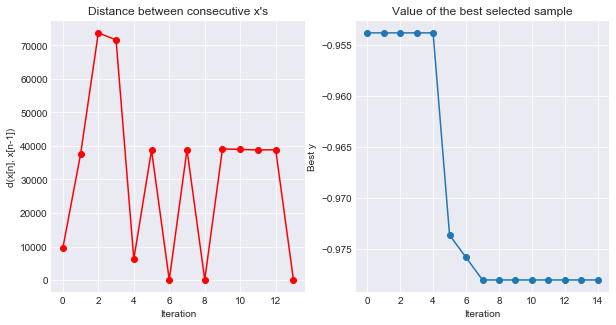

In [223]:
opt.plot_convergence()

In [224]:
params = opt.x_opt
print(opt.x_opt)
model = SVC(C=params[0], gamma=np.exp(params[1]))
model.fit(X_tr, y_tr)
evaluate(model, X_te, y_te)

[ 2.65545802e+04 -8.38235056e+00]
     pred_neg  pred_pos
neg        70         4
pos         0        40
0.9649122807017544


## neural network

In [52]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

In [101]:
model = Sequential()
model.add(Dense(30, input_dim=len(features), activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(15, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [102]:
model.fit(X_tr, y_tr, epochs=10, batch_size=10)

Epoch 1/10
455/455 [==============================] - 1s 2ms/step - loss: 0.5945 - acc: 0.6879
Epoch 2/10
455/455 [==============================] - 0s 298us/step - loss: 0.4168 - acc: 0.8484
Epoch 3/10
455/455 [==============================] - 0s 329us/step - loss: 0.2928 - acc: 0.9363
Epoch 4/10
455/455 [==============================] - 0s 286us/step - loss: 0.2120 - acc: 0.9429
Epoch 5/10
455/455 [==============================] - 0s 308us/step - loss: 0.1917 - acc: 0.9385
Epoch 6/10
455/455 [==============================] - 0s 332us/step - loss: 0.1523 - acc: 0.9648
Epoch 7/10
455/455 [==============================] - 0s 312us/step - loss: 0.1296 - acc: 0.9648
Epoch 8/10
455/455 [==============================] - 0s 324us/step - loss: 0.1223 - acc: 0.9604
Epoch 9/10
455/455 [==============================] - 0s 318us/step - loss: 0.1018 - acc: 0.9692
Epoch 10/10
455/455 [==============================] - 0s 308us/step - loss: 0.0957 - acc: 0.9736


In [108]:
evaluate(model, X_te, y_te)

     pred_neg  pred_pos
neg        65         2
pos         1        46
0.9736842105263158
